In [2]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [4]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [5]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.5 : 
        df.drop(columns = [column], inplace = True)

In [6]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [7]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [8]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]
df_train = df_train.reset_index()

In [9]:
liste_var = ['fam_ENQ','solution','FL_REL_NON_ANNULE','niv_gravite_mtf_dne','CD_SITFAM_EMP1','regroup_natur_op','PTG','fl_fam_vam','fam_PCD','AMI','CD_ETAT_CIVIL','CD_NAT_EMP1','niv_gravite_mtf_dne','FL_REL_NON_ANNULE','sol_echec','fl_def_ss_pass_CTX','nb_empr_ope','CD_MTF_DFC','FL_ETR']

In [10]:
df_train_var = df[liste_var].copy()
df_test_var = df_validation[liste_var].copy()

# Encoding

In [11]:
def encode_columns(df):
    encoders = {}
    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()
        if unique_values <= 10:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False)
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(df_train_var)
encoded_test, encoder_test = encode_columns(df_test_var)

In [12]:
df_train_var['cd_op']  = df['cd_op'].copy()
df_train_var['fl_pass_DET'] = df['fl_pass_DET'].copy()
df_train_var['date_entree_defaut'] = df['date_entree_defaut'].copy()
df_train_var['arrete'] = df['arrete'].copy()

In [13]:
df_test_var['cd_op']  = df_validation['cd_op'].copy()
df_test_var['fl_pass_DET'] = df_validation['fl_pass_DET'].copy()
df_test_var['date_entree_defaut'] = df_validation['date_entree_defaut'].copy()
df_test_var['arrete'] = df_validation['arrete'].copy()

# DataPrep

In [14]:
data_haz = df_train_var.copy()
data_test =df_test_var.copy()

In [15]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [16]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [17]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'fl_pass_DET'], 'stop'] = 0.5 

In [18]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

data_test = data_test.select_dtypes(exclude=["datetime64"])

In [19]:
data_haz.drop(columns = ["cd_op"], inplace = True)


data_test.drop(columns = ["cd_op"], inplace = True)

# Modelisation

In [20]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(data_haz, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 2.90e-01, step_size = 0.9500, log_lik = -86546.11010, newton_decrement = 2.29e+03, seconds_since_start = 73.6
Iteration 2: norm_delta = 1.30e-02, step_size = 0.9500, log_lik = -84302.33994, newton_decrement = 4.92e+00, seconds_since_start = 158.5
Iteration 3: norm_delta = 7.12e-04, step_size = 0.9500, log_lik = -84297.41363, newton_decrement = 1.49e-02, seconds_since_start = 264.4
Iteration 4: norm_delta = 3.77e-05, step_size = 1.0000, log_lik = -84297.39871, newton_decrement = 3.78e-05, seconds_since_start = 371.2
Iteration 5: norm_delta = 7.23e-10, step_size = 1.0000, log_lik = -84297.39868, newton_decrement = 1.54e-14, seconds_since_start = 477.6
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 329064 periods, 23305 subjects, 7463 events>

In [21]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 329064 periods, 23305 subjects, 7463 events>
         event col = 'fl_pass_DET'
         penalizer = 0.1
number of subjects = 23305
 number of periods = 329064
  number of events = 7463
partial log-likelihood = -84297.40
  time fit was run = 2024-01-09 21:18:40 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
fam_ENQ                           0.05       1.05       0.01             0.02             0.07                 1.02                 1.07
solution                         -0.15       0.86       0.01            -0.17            -0.13                 0.84                 0.87
FL_REL_NON_ANNULE                 0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
FL_REL_NON_ANNULE                 0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
niv_gravite_mtf_dne               0.12       1.13       0.02             0.08             0.15                 1.09                 1.16
niv_gravite_mtf_dne               0.12       1.13       0.02             0.08             0.15                 1.09                 1.16
PTG                               0.22       1.24       0.02             0.19             0.25                 1.20                 1.28
fl_fam_vam                        0.08       1.09       0.02             0.05             0.11                 1.05                 1.12
fam_PCD                           0.50       1.65       0.01             0.48             0.52                 1.62                 1.69
AMI                              -0.18       0.83       0.01            -0.20            -0.16                 0.82                 0.85
CD_ETAT_CIVIL                     0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
niv_gravite_mtf_dne               0.12       1.13       0.02             0.08             0.15                 1.09                 1.16
niv_gravite_mtf_dne               0.12       1.13       0.02             0.08             0.15                 1.09                 1.16
FL_REL_NON_ANNULE                 0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
FL_REL_NON_ANNULE                 0.09       1.09       0.03             0.02             0.16                 1.02                 1.17
fl_def_ss_pass_CTX               -0.21       0.81       0.03            -0.27            -0.15                 0.76                 0.86
nb_empr_ope                      -0.04       0.96       0.01            -0.06            -0.02                 0.94                 0.98
CD_MTF_DFC                       -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
FL_ETR                            0.03       1.03       0.02            -0.01             0.06                 0.99                 1.06
CD_SITFAM_EMP1_C                  0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04
CD_SITFAM_EMP1_D                  0.03       1.03       0.02            -0.00             0.07                 1.00                 1.07
CD_SITFAM_EMP1_I                  0.04       1.04       0.06            -0.09             0.16                 0.92                 1.17
CD_SITFAM_EMP1_M                 -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
CD_SITFAM_EMP1_S                 -0.09       0.92       0.10            -0.28             0.10                 0.76                 1.10
CD_SITFAM_EMP1_U                  0.01       1.01       0.01            -0.02             0.04                 0.98       

ValueError: 'x' and 'y' must have the same size

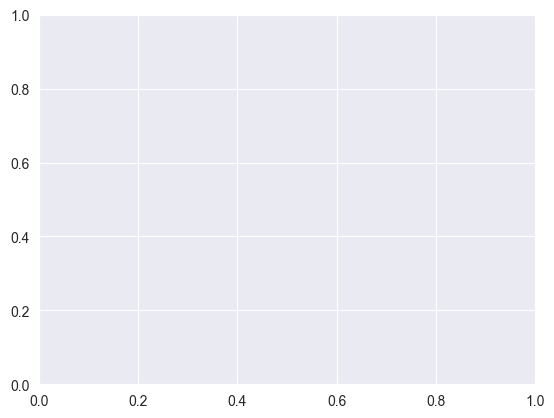

In [23]:
ctv.plot()